# Welcome to GPyEm!

GPyEm is a package used to create independent multi-output emulators for cohort emulation studies using GPyTorch.

In this tutorial we will show how to use GPyEm emulators for a Global Sensitivity Analysis using SALib. 

# Installation
## If you just want to use it...
```
pip install git+https://github.com/cwlanyon/GPyEm.git
```

## If you want to develop it...

Go to where you want to save your repo:
```
git clone https://github.com/cwlanyon/GPyEm.git
pip install -e GPyEm
```
So you can now import this in a python script anywhere you happen to be (no need to worry about paths etc):
```
from GPyEm import GPE_ensemble as GPE
```

## If you already have the repo on your computer...

Go to the location. E.g.
```
cd /home/me/Documents/code/GPyEm
```
Then call:
```
pip install -e .
```


In [120]:
# Import useful libraries

import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pyDOE import *

#Import GPyEm

from GPyEm import GPE_ensemble as GPE 

#Import libraries for sensitivity analysis 

import scipy.stats.qmc as qmc
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

### Establishing the problem

As a simple example we use the function 

$$ f(\theta)=\begin{cases}
f_1(\theta)=(\theta_3\theta_2^2-\theta_1)/\theta_4^2 \\
f_2(\theta)=\sum\theta_i
\end{cases}
$$

In the first case the two m

In [206]:
p=50 # Number of observations

# Sample 4D theta from latin-hypercube
theta_sampler = qmc.LatinHypercube(d=4) 
theta_sample = theta_sampler.random(n=p)

l_bounds = [1,1,1,1]
u_bounds = [10,10,10,10]
theta = torch.tensor(qmc.scale(theta_sample, l_bounds, u_bounds))

In [207]:
def twoD_func(theta): # define f
    return torch.stack([theta[:,3]+(theta[:,2]*theta[:,1]**2-theta[:,0])/theta[:,2]**2,torch.sum(theta,axis=1)],axis=1)

### Train the emulator

In [208]:
X=theta
y=(twoD_func(theta))

# Split data into training and testing

theta_train, theta_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
)

In [209]:
emulator=GPE.ensemble(theta_train,y_train,kernel='RBF') 

0
1


In [210]:
emulator.R2(theta_test,y_test)

tensor([0.9960, 1.0000], dtype=torch.float64, grad_fn=<RsubBackward1>)

# GSA

Here we set up our GSA using SALib. 

We start by taking a large sample from the parameter space.

In [211]:
nDim = theta.shape[1]
boundsMaxMin = []
for i in range(nDim): # Calculates the max and min bounds of the parameters
    boundsMaxMin.append([np.min(theta[:,i].detach().numpy()),np.max(theta[:,i].detach().numpy())])
    print(boundsMaxMin[i])

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': ['$theta_1$','$theta_2$','$theta_3$','$theta_4$'],
    'bounds': boundsMaxMin
}

# Generate samples via a saltelli sample
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1) #use the emulator to predict the f at the sampled parameter values


[1.005653712336757, 9.840643220553778]
[1.141428362247931, 9.909506721445933]
[1.1579527382629875, 9.838483389540139]
[1.0699715722598586, 9.833365545254184]


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_41318/430000757.py:15: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


### Calculate the Sobol indices for each output.

In [212]:
Si = []
nMod = y_train.shape[1]

for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]

                 ST   ST_conf
$theta_1$  0.003033  0.000709
$theta_2$  0.648675  0.099577
$theta_3$  0.502000  0.071031
$theta_4$  0.048461  0.006692
                 S1   S1_conf
$theta_1$  0.000860  0.004282
$theta_2$  0.453462  0.081593
$theta_3$  0.307636  0.089508
$theta_4$  0.042369  0.021110
                              S2   S2_conf
($theta_1$, $theta_2$)  0.000045  0.007438
($theta_1$, $theta_3$)  0.001833  0.010724
($theta_1$, $theta_4$)  0.000947  0.006026
($theta_2$, $theta_3$)  0.173809  0.146645
($theta_2$, $theta_4$) -0.015277  0.100610
($theta_3$, $theta_4$) -0.013964  0.135938
                 ST   ST_conf
$theta_1$  0.253856  0.022699
$theta_2$  0.250323  0.023422
$theta_3$  0.245514  0.018509
$theta_4$  0.250183  0.021444
                 S1   S1_conf
$theta_1$  0.253870  0.040208
$theta_2$  0.250350  0.040404
$theta_3$  0.245493  0.040503
$theta_4$  0.250214  0.037030
                              S2   S2_conf
($theta_1$, $theta_2$) -0.000046  0.066777
($theta_1$, $

### Visualise the first order Sobol indices

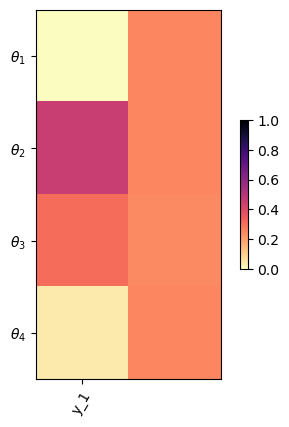

In [213]:
inputs =  ['$\\theta_1$','$\\theta_2$','$\\theta_3$','$\\theta_4$']
outputs = ['y_1']
fig, ax = plt.subplots()
im = ax.imshow(Si_first,cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)